# Data 


In [0]:
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import files

# ---------- File Loading ---------- #
dev_link = 'https://raw.githubusercontent.com/stepmolotov/MachineLearning-CUP-2019/master/ML-CUP19-TR.csv'
# dropping comments (first 7 rows)
data = pd.read_csv(dev_link, skiprows=7, header=None)
# print('before: ({},{})'.format(data.shape[0], data.shape[1]))
# dropping indexes column
data.drop(axis=1, columns=0, inplace=True)
# data.head()

In [0]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score

# ----- Splitting Data ----- #
target = data[data.columns[-2:]]
target.columns = ['x', 'y']
X = data[data.columns[:-2]]
y = target
# y.plot(kind='scatter', x='x', y='y')
print('X: ({},{})'.format(X.shape[0], X.shape[1]))
print('y: ({},{})'.format(y.shape[0], y.shape[1]))

# keeping out some rows as the test set
X = X.values
y = y.values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)


X: (1765,20)
y: (1765,2)


# SVM

In [0]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [0]:
# Gets the best models out of the grid search results
def report(results, n_top=3, metric='loss', simple=False):
  if simple:
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
  else:
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_'+metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("(loss) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  -1*results['mean_test_loss'][candidate],
                  results['std_test_loss'][candidate]))
            print("(mee) Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_mee'][candidate],
                  results['std_test_mee'][candidate]))
            print("--- Parameters: {0}".format(results['params'][candidate]))
            print("")

from sklearn.metrics import make_scorer

def mean_euclidean_error(X, Y):
    sum = 0
    for x, y in zip(X, Y):
        sum += np.linalg.norm(x - y, ord=2)
    return sum / X.shape[0]

#scoring = {'loss': 'neg_mean_squared_error', 'mee': make_scorer(mean_euclidean_error)}
scores = {'loss': 'neg_mean_squared_error', 'mee': make_scorer(mean_euclidean_error)}

In [0]:
# defining pipelines
rbf_pipe = Pipeline([('reg', MultiOutputRegressor(SVR(verbose=True, kernel='rbf')))])
poly_pipe = Pipeline([('reg', MultiOutputRegressor(SVR(verbose=True, kernel='poly')))])

In [0]:
rbf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'reg', 'reg__estimator__C', 'reg__estimator__cache_size', 'reg__estimator__coef0', 'reg__estimator__degree', 'reg__estimator__epsilon', 'reg__estimator__gamma', 'reg__estimator__kernel', 'reg__estimator__max_iter', 'reg__estimator__shrinking', 'reg__estimator__tol', 'reg__estimator__verbose', 'reg__estimator', 'reg__n_jobs'])

## RBF Kernel

In [0]:
# pipeline version
grid_params = {
    'reg__estimator__gamma': ['scale', 'auto'],
    'reg__estimator__epsilon': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'reg__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'reg__estimator__shrinking': [True]
    #'reg__estimator__degree': [2, 3, 4]
}

rbf_hyp_search = GridSearchCV(estimator=rbf_pipe, param_grid=grid_params, cv=10, scoring=scores, n_jobs=-1, verbose=1, refit=False, return_train_score=True)

start = time.time()
rbf_hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))

Fitting 10 folds for each of 196 candidates, totalling 1960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed: 58.6min


Grid time: 3607.62411904335


[Parallel(n_jobs=-1)]: Done 1960 out of 1960 | elapsed: 60.1min finished


In [0]:
results = pd.DataFrame(rbf_hyp_search.cv_results_)
results.sort_values(by=['param_reg__estimator__epsilon'], inplace=True, ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator__C,param_reg__estimator__epsilon,param_reg__estimator__gamma,param_reg__estimator__shrinking,params,split0_test_loss,split1_test_loss,split2_test_loss,split3_test_loss,split4_test_loss,split5_test_loss,split6_test_loss,split7_test_loss,split8_test_loss,split9_test_loss,mean_test_loss,std_test_loss,rank_test_loss,split0_train_loss,split1_train_loss,split2_train_loss,split3_train_loss,split4_train_loss,split5_train_loss,split6_train_loss,split7_train_loss,split8_train_loss,split9_train_loss,mean_train_loss,std_train_loss,split0_test_mee,split1_test_mee,split2_test_mee,split3_test_mee,split4_test_mee,split5_test_mee,split6_test_mee,split7_test_mee,split8_test_mee,split9_test_mee,mean_test_mee,std_test_mee,rank_test_mee,split0_train_mee,split1_train_mee,split2_train_mee,split3_train_mee,split4_train_mee,split5_train_mee,split6_train_mee,split7_train_mee,split8_train_mee,split9_train_mee,mean_train_mee,std_train_mee
195,0.007650,0.000377,0.002802,0.000210,1000,1000,auto,False,"{'reg__estimator__C': 1000, 'reg__estimator__e...",-43.168176,-38.87498,-41.189353,-40.493249,-40.898215,-46.789697,-40.079989,-44.788576,-38.036566,-46.186497,-42.05053,2.878986,141,-41.927827,-42.407854,-42.156542,-42.215984,-42.180624,-41.527045,-42.27183,-41.736835,-42.498085,-41.593962,-42.051659,0.320692,8.790703,8.327945,8.598178,8.505083,8.523782,9.192649,8.452702,8.950118,8.228084,9.036912,8.660616,0.30219,29,8.646421,8.698162,8.670038,8.676714,8.676145,8.601944,8.684095,8.625639,8.708949,8.619221,8.660733,0.033863
81,0.007702,0.002042,0.003812,0.000686,0.1,1000,scale,False,"{'reg__estimator__C': 0.1, 'reg__estimator__ep...",-43.168176,-38.87498,-41.189353,-40.493249,-40.898215,-46.789697,-40.079989,-44.788576,-38.036566,-46.186497,-42.05053,2.878986,141,-41.927827,-42.407854,-42.156542,-42.215984,-42.180624,-41.527045,-42.27183,-41.736835,-42.498085,-41.593962,-42.051659,0.320692,8.790703,8.327945,8.598178,8.505083,8.523782,9.192649,8.452702,8.950118,8.228084,9.036912,8.660616,0.30219,29,8.646421,8.698162,8.670038,8.676714,8.676145,8.601944,8.684095,8.625639,8.708949,8.619221,8.660733,0.033863
27,0.008125,0.003379,0.004278,0.001408,0.001,1000,auto,False,"{'reg__estimator__C': 0.001, 'reg__estimator__...",-43.168176,-38.87498,-41.189353,-40.493249,-40.898215,-46.789697,-40.079989,-44.788576,-38.036566,-46.186497,-42.05053,2.878986,141,-41.927827,-42.407854,-42.156542,-42.215984,-42.180624,-41.527045,-42.27183,-41.736835,-42.498085,-41.593962,-42.051659,0.320692,8.790703,8.327945,8.598178,8.505083,8.523782,9.192649,8.452702,8.950118,8.228084,9.036912,8.660616,0.30219,29,8.646421,8.698162,8.670038,8.676714,8.676145,8.601944,8.684095,8.625639,8.708949,8.619221,8.660733,0.033863
26,0.005233,0.001300,0.003679,0.000328,0.001,1000,auto,True,"{'reg__estimator__C': 0.001, 'reg__estimator__...",-43.168176,-38.87498,-41.189353,-40.493249,-40.898215,-46.789697,-40.079989,-44.788576,-38.036566,-46.186497,-42.05053,2.878986,141,-41.927827,-42.407854,-42.156542,-42.215984,-42.180624,-41.527045,-42.27183,-41.736835,-42.498085,-41.593962,-42.051659,0.320692,8.790703,8.327945,8.598178,8.505083,8.523782,9.192649,8.452702,8.950118,8.228084,9.036912,8.660616,0.30219,29,8.646421,8.698162,8.670038,8.676714,8.676145,8.601944,8.684095,8.625639,8.708949,8.619221,8.660733,0.033863
25,0.008150,0.001997,0.003772,0.001045,0.001,1000,scale,False,"{'reg__estimator__C': 0.001, 'reg__estimator__...",-43.168176,-38.87498,-41.189353,-40.493249,-40.898215,-46.789697,-40.079989,-44.788576,-38.036566,-46.186497,-42.05053,2.878986,141,-41.927827,-42.407854,-42.156542,-42.215984,-42.180624,-41.527045,-42.27183,-41.736835,-42.498085,-41.593962,-42.051659,0.320692,8.790703,8.327945,8.598178,8.505083,8.523782,9.192649,8.452702,8.950118,8.228084,9.036912,8.660616,0.30219,29,8.646421,8.698162,8.670038,8.676714,8.676145,8.601944,8.684095,8.625639,8.708949,8.619221,8.660733,0.033863


In [0]:
report(results=rbf_hyp_search.cv_results_, n_top=6)

Model with rank: 1
(loss) Mean validation score: 0.9443 (std: 0.1203)
(mee) Mean validation score: 1.0076 (std: 0.0520)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': True}

Model with rank: 2
(loss) Mean validation score: 0.9443 (std: 0.1203)
(mee) Mean validation score: 1.0076 (std: 0.0520)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': False}

Model with rank: 3
(loss) Mean validation score: 0.9467 (std: 0.1247)
(mee) Mean validation score: 1.0107 (std: 0.0543)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'scale', 'reg__estimator__shrinking': True}

Model with rank: 4
(loss) Mean validation score: 0.9467 (std: 0.1247)
(mee) Mean validation score: 1.0107 (std: 0.0543)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estim

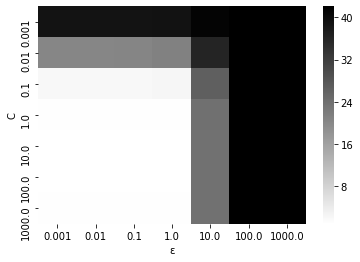

In [0]:
# Heatmap print
results_heat = pd.DataFrame()
results_heat['C'] = results['param_reg__estimator__C']
results_heat['ε'] = results['param_reg__estimator__epsilon']
results_heat['MSE'] = -1*results['mean_test_loss']
results_heat = results_heat.apply(lambda x: pd.to_numeric(x), axis=0)

heatmap_data = pd.pivot_table(results_heat, values='MSE', 
                     index=['C'], 
                     columns='ε')
ax = sns.heatmap(heatmap_data, cmap='binary')

Snipe Grid

In [0]:
# snipe grid 
grid_params = {
    'reg__estimator__gamma': ['scale', 'auto'],
    'reg__estimator__epsilon': [0.01, 0.025, 0.05, 0.75, 0.1],
    'reg__estimator__C': [50, 75, 100, 125, 175, 250],
    'reg__estimator__shrinking': [True]
    #'reg__estimator__degree': [2, 3, 4]
}

rbf_snipe_hyp_search = GridSearchCV(estimator=rbf_pipe, param_grid=grid_params, cv=10, scoring=scores, n_jobs=-1, verbose=1, refit=False, return_train_score=True)

start = time.time()
rbf_snipe_hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.9min


Grid time: 1091.840547800064


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 18.2min finished


In [0]:
report(results=rbf_snipe_hyp_search.cv_results_, n_top=5)

Model with rank: 1
(loss) Mean validation score: 0.9443 (std: 0.1203)
(mee) Mean validation score: 1.0076 (std: 0.0520)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': True}

Model with rank: 2
(loss) Mean validation score: 0.9460 (std: 0.1110)
(mee) Mean validation score: 1.0056 (std: 0.0480)
--- Parameters: {'reg__estimator__C': 125, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': True}

Model with rank: 3
(loss) Mean validation score: 0.9467 (std: 0.1247)
(mee) Mean validation score: 1.0107 (std: 0.0543)
--- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'scale', 'reg__estimator__shrinking': True}

Model with rank: 4
(loss) Mean validation score: 0.9471 (std: 0.1158)
(mee) Mean validation score: 1.0077 (std: 0.0496)
--- Parameters: {'reg__estimator__C': 125, 'reg__estimator__epsilon': 0.1, 'reg__estima

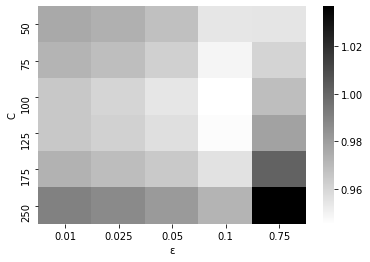

In [0]:
# Heatmap print
snipe_heat['C'] = snipe['param_reg__estimator__C']
snipe_heat['ε'] = snipe['param_reg__estimator__epsilon']
snipe_heat['MSE'] = -1*snipe['mean_test_loss']
snipe_heat = snipe_heat.apply(lambda x: pd.to_numeric(x), axis=0)

heatmap_data = pd.pivot_table(snipe_heat, values='MSE', 
                     index=['C'], 
                     columns='ε')
ax = sns.heatmap(heatmap_data, cmap='binary')

### RBF Best Model Plot

In [0]:
# Model with rank: 1
# (loss) Mean validation score: 0.9443 (std: 0.1203)
# (mee) Mean validation score: 1.0076 (std: 0.0520)
# --- Parameters: {'reg__estimator__C': 100, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': True}

best_rbf = MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.1, shrinking=True))

start = time.time()
best_rbf.fit(train_X, train_y)
end = time.time()
print('SVM - RBF time: ' + str(end - start))

SVM - RBF time: 2.6649363040924072


In [0]:
y_pred = best_rbf.predict(test_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred)
print('Test LOSS : ' + str(mse))
mee = mean_euclidean_error(test_y, y_pred)
print('Test MEE : ' + str(mee))

Test LOSS : 1.1031501356610036
Test MEE : 1.0443869707562303


Text(26, -14.5, 'MEE: 1.0444')

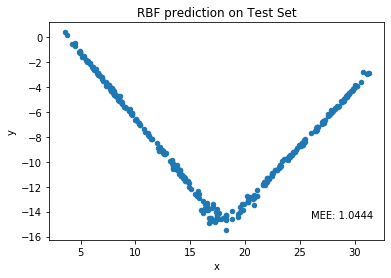

In [0]:
# RBF V on our test_X
y_pred = best_rbf.predict(test_X)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')
plt.title('RBF prediction on Test Set')
plt.text(26,-14.5, 'MEE: %.4f' % (mee))
# y_pred.head()

In [0]:
from sklearn.model_selection import cross_validate
rbf_cv = cross_validate(best_rbf, train_X, train_y, cv=10, scoring=scores)
rbf_cv

{'fit_time': array([2.10373425, 2.29518342, 2.13580012, 2.15350556, 2.18935156,
        2.13480067, 1.98864889, 2.09882164, 2.09513736, 2.03369069]),
 'score_time': array([0.01803899, 0.01799273, 0.01813364, 0.01750803, 0.01833224,
        0.01721191, 0.0177772 , 0.01778507, 0.01790714, 0.01781607]),
 'test_loss': array([-0.99025994, -0.85701408, -1.12856083, -1.1173713 , -0.78650975,
        -0.90748341, -0.90564049, -0.86866251, -0.80370172, -1.07779983]),
 'test_mee': array([1.03900466, 0.94470452, 1.09691357, 1.07612034, 0.93854912,
        1.03218762, 0.97284393, 1.00018318, 0.95641373, 1.0189927 ])}

In [0]:
rbf_val_loss = -1*rbf_cv['test_loss'].mean()
rbf_val_mee = rbf_cv['test_mee'].mean()
print('RBF Loss: ' + str(rbf_val_loss))
print('RBF MEE: ' + str(rbf_val_mee))

RBF Loss: 0.9443003880472478
RBF MEE: 1.0075913356167916


In [0]:
from sklearn.model_selection import learning_curve
x_size = train_X.shape[0]/10 * 9
print(x_size)
train_sizes = np.arange(1, 1271, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator=best_RBF, X=train_X, y=train_y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error', verbose=1)

In [0]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
# print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
# print('\n', '-' * 20) # separator
# print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

In [0]:
print('Train: %.4f, Val: %.4f' % (train_scores_mean[-1], validation_scores_mean[-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation', ls='--')
plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('RBF Learning curve')
plt.legend()
plt.grid()
# plt.ylim(0,7)

## Poly Kernel


In [0]:
# polynomial version
grid_params = {
    'reg__estimator__gamma': ['scale', 'auto'],
    'reg__estimator__coef0': [0, 0.5, 1, 2],
    'reg__estimator__epsilon': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'reg__estimator__C': [0.1, 1, 10, 100],#[0.001, 0.01, 0.1, 1, 10, 100],#, 1000],
    'reg__estimator__shrinking': [True],
    'reg__estimator__degree': [2, 3, 4, 5, 6]
}

snipe_grid_params = {
    'reg__estimator__gamma': ['auto'],
    'reg__estimator__coef0': [0.4, 0.5, 0.6, 0.7],
    'reg__estimator__epsilon': [0.1],
    'reg__estimator__C': [5, 6, 7, 8, 9, 10],
    'reg__estimator__shrinking': [True],
    'reg__estimator__degree': [2, 3, 4]
}

best_grid_params = {
    'reg__estimator__gamma': ['auto'],
    'reg__estimator__coef0': [0.9],
    'reg__estimator__epsilon': [0.1],
    'reg__estimator__C': [1],
    'reg__estimator__shrinking': [True],
    'reg__estimator__degree': [5]    
}

poly_hyp_search = GridSearchCV(estimator=poly_pipe, param_grid=best_grid_params, cv=10, 
                               scoring=scores, n_jobs=2, verbose=1, refit=False, return_train_score=True)

start = time.time()
poly_hyp_search.fit(train_X, train_y)
end = time.time()
print('Grid time: ' + str(end - start))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Grid time: 10.101204872131348


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   10.1s finished


### POLY Best Model



In [0]:
report(poly_hyp_search.cv_results_, n_top=5)

Model with rank: 1
(loss) Mean validation score: 1.0348 (std: 0.1594)
(mee) Mean validation score: 1.0711 (std: 0.0734)
--- Parameters: {'reg__estimator__C': 1, 'reg__estimator__coef0': 0.9, 'reg__estimator__degree': 5, 'reg__estimator__epsilon': 0.1, 'reg__estimator__gamma': 'auto', 'reg__estimator__shrinking': True}



In [0]:
best_POLY = MultiOutputRegressor(SVR(kernel='poly', C=1, gamma='auto', epsilon=0.1, coef0=0.9, degree=5, shrinking=True))

start = time.time()
best_POLY.fit(train_X, train_y)
end = time.time()
print('SVM - POLY time: ' + str(end - start))

y_pred = best_POLY.predict(test_X)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred)
print('Test LOSS : ' + str(mse))
mee = mean_euclidean_error(test_y, y_pred)
print('Test MEE : ' + str(mee))

SVM - POLY time: 1.4066734313964844
Test LOSS : 1.1727993605395346
Test MEE : 1.0866432276600715


Text(26, -14.5, 'MEE: 1.0866')

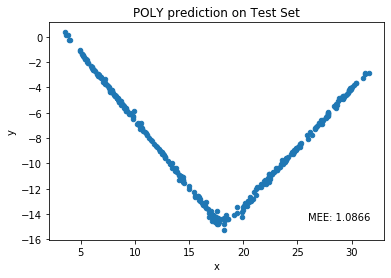

In [0]:
# POLY V on our test_X
y_pred = best_POLY.predict(test_X)
y_pred = pd.DataFrame(y_pred, columns=['x', 'y'])

y_pred.plot(kind='scatter', x='x', y='y')
plt.title('POLY prediction on Test Set')
plt.text(26,-14.5, 'MEE: %.4f' % (mee))
# y_pred.head()

In [0]:
from sklearn.model_selection import learning_curve
x_size = train_X.shape[0]/10 * 9
print(x_size)
train_sizes = np.arange(1, 1271, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator=best_POLY, X=train_X, y=train_y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error', verbose=1)

1270.8
[learning_curve] Training set sizes: [   1   11   21   31   41   51   61   71   81   91  101  111  121  131
  141  151  161  171  181  191  201  211  221  231  241  251  261  271
  281  291  301  311  321  331  341  351  361  371  381  391  401  411
  421  431  441  451  461  471  481  491  501  511  521  531  541  551
  561  571  581  591  601  611  621  631  641  651  661  671  681  691
  701  711  721  731  741  751  761  771  781  791  801  811  821  831
  841  851  861  871  881  891  901  911  921  931  941  951  961  971
  981  991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111
 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251
 1261]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1270 out of 1270 | elapsed:  9.5min finished


In [0]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

Train: 0.7023, Val: 1.0339


(0, 7)

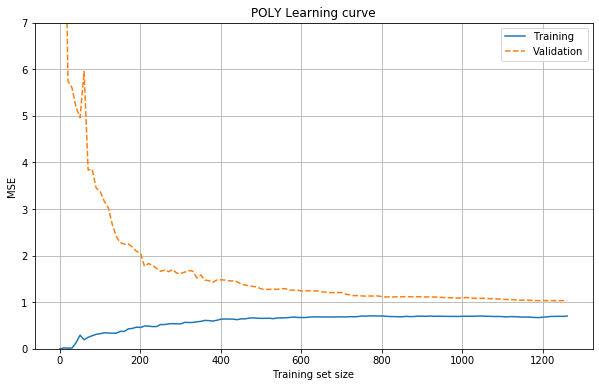

In [0]:
print('Train: %.4f, Val: %.4f' % (train_scores_mean[-1], validation_scores_mean[-1]))
# plot loss during training
plt.figure(figsize=(10,6))#da rivedere
plt.plot(train_sizes, train_scores_mean, label = 'Training')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation', ls='--')
plt.ylabel('MSE')
plt.xlabel('Training set size')
plt.title('POLY Learning curve')
plt.legend()
plt.grid()
plt.ylim(0,7)

### Older Grid

In [0]:
grid_params = {
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.15, 0.2, 0.25, 0.3],
    'C': [1, 10, 25],
    'shrinking': [True],
    'degree': [2, 3, 4],
    'coef0': [0, 0.1, 0.2]
}

start = time.time()

poly_estimator = SVR(kernel='poly', verbose=1)
poly_model = MultiOutputRegressor(estimator=GridSearchCV(estimator=poly_estimator, param_grid=grid_params, cv=10, scoring='neg_mean_squared_error', n_jobs=4, verbose=1))


end = time.time()
print('Grid time: ' + str(end - start))

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 2700 out of 2700 | elapsed: 11.3min finished


[LibSVM]Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 2700 out of 2700 | elapsed: 12.6min finished


[LibSVM]

MultiOutputRegressor(estimator=GridSearchCV(cv=10, error_score=nan,
                                            estimator=SVR(C=1.0, cache_size=200,
                                                          coef0=0.0, degree=3,
                                                          epsilon=0.1,
                                                          gamma='scale',
                                                          kernel='poly',
                                                          max_iter=-1,
                                                          shrinking=True,
                                                          tol=0.001,
                                                          verbose=1),
                                            iid='deprecated', n_jobs=4,
                                            param_grid={'C': [1, 10, 25],
                                                        'coef0': [0, 0.1, 0.2],
                                             

In [0]:
poly_model.fit(train_X, train_y)
y_pred = poly_model.predict(test_X)

from sklearn.metrics import mean_squared_error
sse = mean_squared_error(test_y, y_pred)
print('SSE : ' + str(sse))

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.2s


KeyboardInterrupt: ignored